In [1]:
import numpy as np
import matplotlib.pyplot as plt

# expensive function
def expensive_f(x):
    return np.sin(x) + 0.1*x**2

# training data
x_train = np.linspace(-5, 5, 20)
y_train = expensive_f(x_train)

In [14]:
# fit a polynomial surrogate (degree 5)
coeffs = np.polyfit(x_train, y_train, 6)
surrogate = np.poly1d(coeffs)

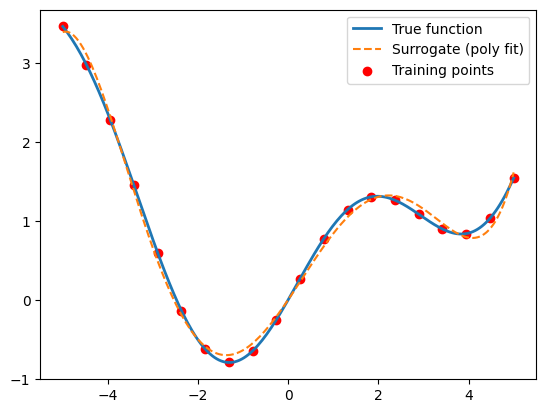

In [15]:
x_test = np.linspace(-5, 5, 200)
y_true = expensive_f(x_test)
y_sur = surrogate(x_test)

plt.plot(x_test, y_true, label="True function", lw=2)
plt.plot(x_test, y_sur, "--", label="Surrogate (poly fit)")
plt.scatter(x_train, y_train, color="red", label="Training points")
plt.legend()
plt.show()

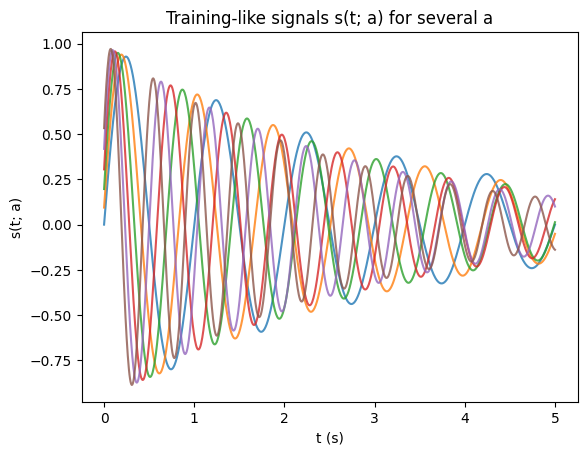

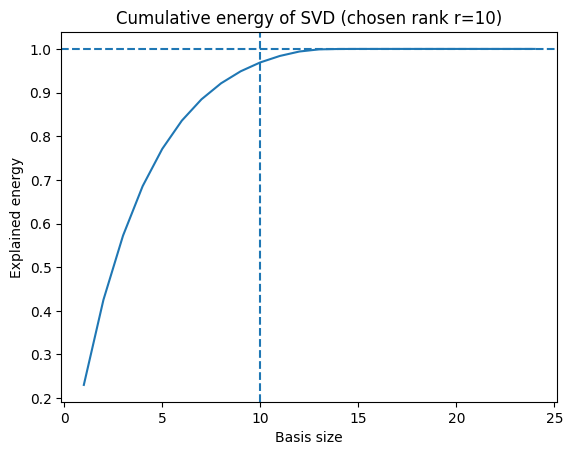

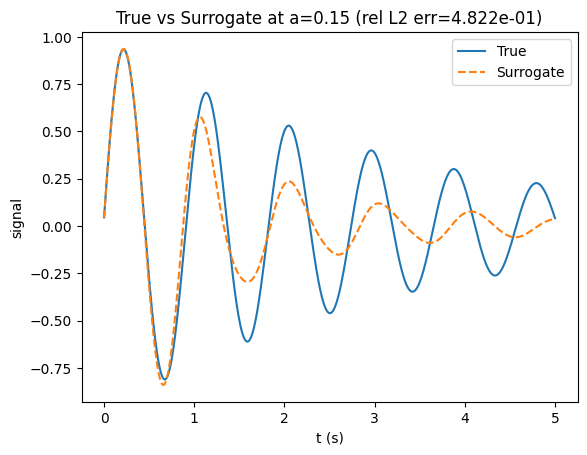

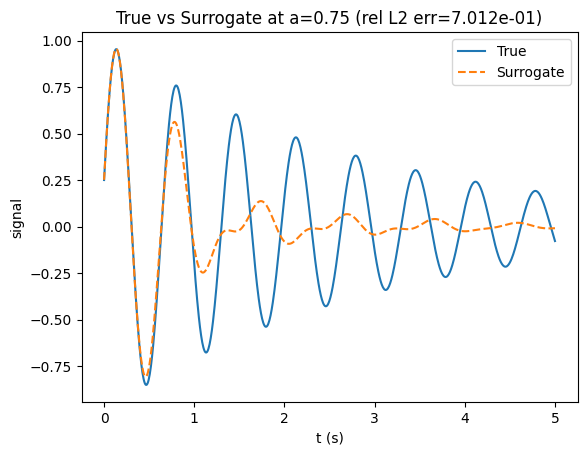

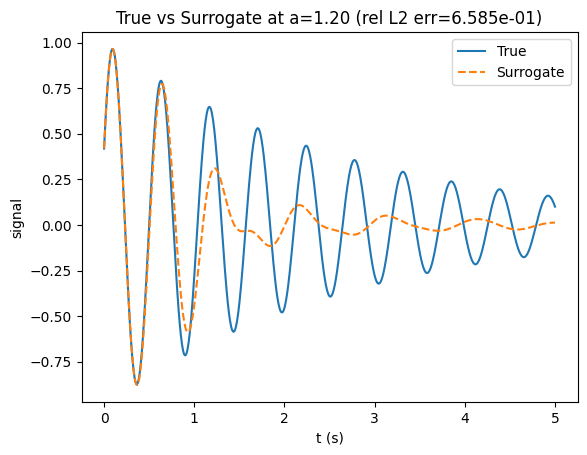

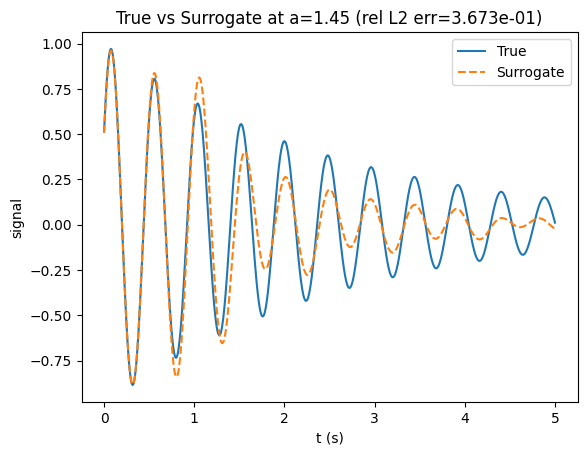

Chosen rank r = 10
a=0.15  relative L2 error = 4.822e-01
a=0.75  relative L2 error = 7.012e-01
a=1.20  relative L2 error = 6.585e-01
a=1.45  relative L2 error = 3.673e-01


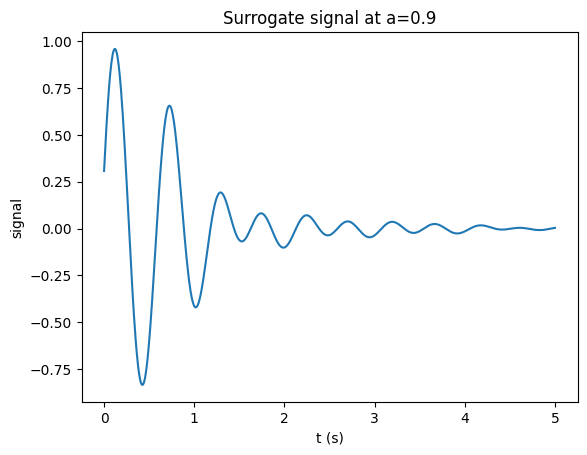

In [16]:
# Toy 1-parameter surrogate for a time-series signal s(t; a)
import numpy as np
import matplotlib.pyplot as plt

# 1) Define the "expensive" simulator
def expensive_signal(t, a):
    # Damped, slightly nonlinear frequency and phase dependence on 'a'
    freq = 1.0 + 0.6*a + 0.1*a**2        # Hz (toy)
    phase = 0.3*a + 0.05*a**2
    envelope = np.exp(-0.3*t*(1+0.2*a))  # damping grows mildly with 'a'
    return envelope * np.sin(2*np.pi*freq*t + phase)

# Time grid
t = np.linspace(0, 5, 800)  # 5 seconds, 800 samples

# 2) Build training set over 'a'
a_train = np.linspace(0.0, 1.5, 24)  # training parameter values
S = np.column_stack([expensive_signal(t, a) for a in a_train])  # shape (T, N)

# 3) SVD basis
U, s, Vt = np.linalg.svd(S, full_matrices=False)
energy = np.cumsum(s**2) / np.sum(s**2)
# Choose rank r to capture 99.9% of energy (cap at 10 to keep it small)
r = min(np.searchsorted(energy, 0.999) + 1, 10)
Ur = U[:, :r]
sr = s[:r]
Vtr = Vt[:r, :]

# Coefficients for training signals in reduced basis
C_train = (np.diag(sr) @ Vtr)  # shape (r, N)

# 4) Fit coefficient maps: a -> each coefficient
deg = 3
coefs_poly = [np.polyfit(a_train, C_train[i, :], deg) for i in range(r)]
poly_models = [np.poly1d(c) for c in coefs_poly]

# Utility: fast surrogate evaluate at any a_star
def surrogate_signal(a_star):
    # Predict reduced coefficients
    c_pred = np.array([p(a_star) for p in poly_models])  # shape (r,)
    # Reconstruct signal
    return Ur @ c_pred

# --- Demo & diagnostics ---

# Pick some test a values (including ones not in training)
a_test = [0.15, 0.75, 1.2, 1.45]

# Plot a few training signals to see diversity
plt.figure()
for a in np.linspace(0.0, 1.5, 6):
    plt.plot(t, expensive_signal(t, a), alpha=0.8)
plt.title("Training-like signals s(t; a) for several a")
plt.xlabel("t (s)")
plt.ylabel("s(t; a)")
plt.show()

# Plot cumulative energy to show chosen rank r
plt.figure()
plt.plot(np.arange(1, len(energy)+1), energy)
plt.axhline(0.999, linestyle="--")
plt.axvline(r, linestyle="--")
plt.title(f"Cumulative energy of SVD (chosen rank r={r})")
plt.xlabel("Basis size")
plt.ylabel("Explained energy")
plt.show()

# Compare true vs surrogate for each test a and report relative L2 error
errs = {}
for a in a_test:
    y_true = expensive_signal(t, a)
    y_sur = surrogate_signal(a)
    rel_l2 = np.linalg.norm(y_true - y_sur) / np.linalg.norm(y_true)
    errs[a] = rel_l2

    plt.figure()
    plt.plot(t, y_true, label="True")
    plt.plot(t, y_sur, linestyle="--", label="Surrogate")
    plt.title(f"True vs Surrogate at a={a:.2f} (rel L2 err={rel_l2:.3e})")
    plt.xlabel("t (s)")
    plt.ylabel("signal")
    plt.legend()
    plt.show()

# Print quick summary
print("Chosen rank r =", r)
for a, e in errs.items():
    print(f"a={a:.2f}  relative L2 error = {e:.3e}")

# Provide a convenience function students can call:
def evaluate_surrogate_at(a_value):
    return surrogate_signal(a_value)

# Create a simple example output for a_value = 0.9
a_value = 0.9
y_example = evaluate_surrogate_at(a_value)
plt.figure()
plt.plot(t, y_example)
plt.title(f"Surrogate signal at a={a_value}")
plt.xlabel("t (s)")
plt.ylabel("signal")
plt.show()